Name: Faiza Tasnim
ID: 19-41552-3
Sec: C

**Connect with Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import dataset from drive and unzip it**

In [ ]:
from zipfile import ZipFile
with ZipFile ('/content/drive/MyDrive/Face Mask Dataset.zip', 'r') as zipObj:
  zipObj.extractall('drive/MyDrive/content/datasets')

**Import libraries from Tensorflow**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

**Import libraries from Sklearn**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

**Import other libraries**

In [ ]:
import glob as gb
import pathlib
import pandas as pd
import scipy
import random
import seaborn as sns
import os
from PIL import Image
from tqdm import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

**Resize and link the dataset**

In [ ]:
resize = 224
learning_rate = 1e-4
seed = 107
INIT_LR = 1e-4
EPOCHS = 8
BS = 64

dir_mask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithMask'
dir_inc_mask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/incorrect_mask'
dir_nomask = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithoutMask'
TRAIN_DIR = '/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train'
TEST_DIR ='/content/drive/MyDrive/content/datasets/Face Mask Dataset/Test'
VAL_DIR='/content/drive/MyDrive/content/datasets/Face Mask Dataset/Validation'

assert os.path.exists(dir_mask), 'Could not find' + dir_mask
assert os.path.exists(dir_inc_mask), 'Could not find' + dir_inc_mask
assert os.path.exists(dir_nomask), 'Could not find' + dir_nomask

**Show the graph of the catagories**

100%|██████████| 3/3 [00:00<00:00, 49.99it/s]


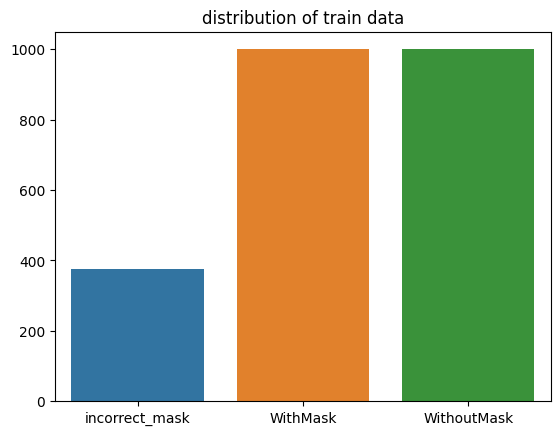

2376


100%|██████████| 1000/1000 [00:02<00:00, 349.16it/s]


In [ ]:
categories = []
class_count = []
train_exm = 0

for f in tqdm(os.listdir(TRAIN_DIR)):
    files = gb.glob(pathname=str(TRAIN_DIR  + '//' + f + '/*'))
    categories.append(f)
    class_count.append(len(files))
    train_exm += len(files)

sns.barplot(x=categories, y=class_count).set_title("distribution of train data")
plt.show()
print(train_exm)

CATEGORIES = ["with_mask", "mask_weared_incorrect", "without_mask"]
data = []
labels = []

for c in categories:
    path = os.path.join(TRAIN_DIR, c)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(resize, resize))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(c)

data= np.array(data, dtype="float32")
labels = np.array(labels)

**See the labels**

In [ ]:
len(labels)

2376

**Count of the catagories**

In [ ]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{'WithMask': 1000, 'WithoutMask': 1000, 'incorrect_mask': 376}

**Show the array**

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
AugmentedData = ImageDataGenerator(
    zoom_range=0.1,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    )

**Show the With mask image**

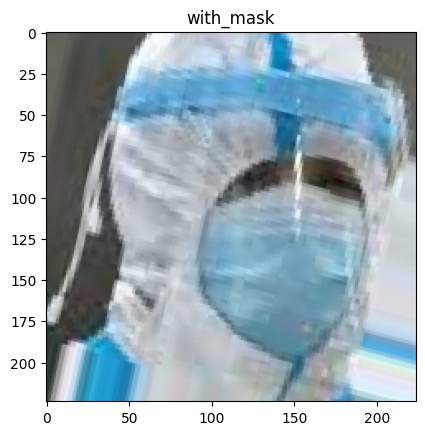

In [ ]:
image1 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithMask/Augmented_154_1675731.png')
plt.figure('image1')
plt.title("with_mask")
plt.imshow(image1)

**Show the inccorect mask image**

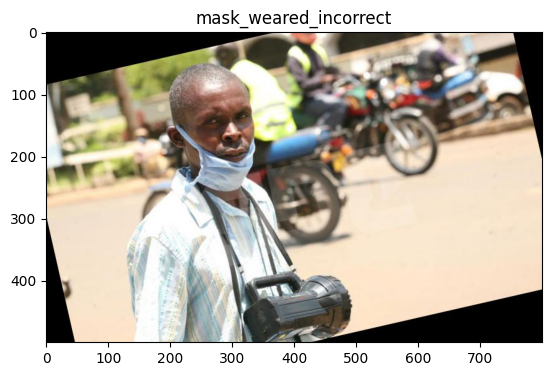

In [ ]:
image2 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/incorrect_mask/aug_100.jpg')
plt.figure('image2')
plt.title("mask_weared_incorrect")
plt.imshow(image2)

**Show the Without mask image**

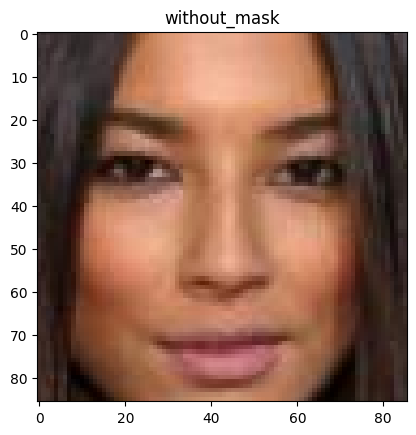

In [ ]:
image3 = Image.open('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithoutMask/3089.png')
plt.figure('image3')
plt.title("without_mask")
plt.imshow(image3)

**Link the test dataset**

In [ ]:
test_data = []
test_labels = []

with_mask_dir = os.path.join(TEST_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Test/WithMask")
without_mask_dir = os.path.join(TEST_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Test/WithoutMask")
improper_mask_dir = os.path.join(TEST_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Test/incorrect_mask")

for a in os.listdir(improper_mask_dir):
    image = cv2.imread(os.path.join(improper_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    test_data.append(image)
    test_labels.append(2)

for a in os.listdir(with_mask_dir):
    image = cv2.imread(os.path.join(with_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    test_data.append(image)
    test_labels.append(1)

for a in os.listdir(without_mask_dir):
    image = cv2.imread(os.path.join(without_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    test_data.append(image)
    test_labels.append(0)

**Shape of test data**

In [ ]:
test_data = np.array(test_data) / 255.0
test_labels = np.array(test_labels)

print(f"Test Data Shape \t: {test_data.shape}")
print(f"Test Label Shape\t: {test_labels.shape}")

Test Data Shape 	: (1125, 224, 224, 3)
Test Label Shape	: (1125,)


**Link the validation dataset**

In [ ]:
val_data = []
val_labels = []

with_mask_dir = os.path.join(VAL_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Validation/WithMask")
without_mask_dir = os.path.join(VAL_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Validation/WithoutMask")
improper_mask_dir = os.path.join(VAL_DIR, "/content/drive/MyDrive/content/datasets/Face Mask Dataset/Validation/incorrect_mask")

for a in os.listdir(improper_mask_dir):
    image = cv2.imread(os.path.join(improper_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    val_data.append(image)
    val_labels.append(2)

for a in os.listdir(with_mask_dir):
    image = cv2.imread(os.path.join(with_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    val_data.append(image)
    val_labels.append(1)

for a in os.listdir(without_mask_dir):
    image = cv2.imread(os.path.join(without_mask_dir, a))
    image = cv2.resize(image, (224, 224))
    val_data.append(image)
    val_labels.append(0)

**Shape of validation data**

In [ ]:
val_data = np.array(val_data) / 255.0
val_labels = np.array(val_labels)

print(f"Validation Data Shape \t: {val_data.shape}")
print(f"Validation Label Shape\t: {val_labels.shape}")

Validation Data Shape 	: (976, 224, 224, 3)
Validation Label Shape	: (976,)


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.2, stratify=labels, random_state=42)

print(f"Shape of x_train: {trainX.shape}")
print(f"Shape of y_train: {trainY.shape}")
print()
print(f"Shape of x_test: {testX.shape}")
print(f"Shape of y_test: {testY.shape}")

Shape of x_train: (1900, 224, 224, 3)
Shape of y_train: (1900, 3)

Shape of x_test: (476, 224, 224, 3)
Shape of y_test: (476, 3)


**Use MobileNetV2 model**

In [ ]:
baseModel = MobileNetV2(input_shape= [224,224,3], weights='imagenet', include_top=False)
baseModel.summary()
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

**Compile the model and execute 5 epoch**

In [ ]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("""[INFO] compiling model...
[INFO] training head...""")
H = model.fit(
    AugmentedData.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

[INFO] compiling model...
[INFO] training head...
Epoch 1/8
29/29 [==============================] - 40s 913ms/step - loss: 0.4569 - accuracy: 0.8208 - val_loss: 0.1947 - val_accuracy: 0.9391
Epoch 2/8
29/29 [==============================] - 22s 769ms/step - loss: 0.1457 - accuracy: 0.9597 - val_loss: 0.1245 - val_accuracy: 0.9538
Epoch 3/8
29/29 [==============================] - 23s 787ms/step - loss: 0.1035 - accuracy: 0.9711 - val_loss: 0.1055 - val_accuracy: 0.9601
Epoch 4/8
29/29 [==============================] - 22s 743ms/step - loss: 0.0809 - accuracy: 0.9782 - val_loss: 0.0884 - val_accuracy: 0.9622
Epoch 5/8
29/29 [==============================] - 26s 887ms/step - loss: 0.0646 - accuracy: 0.9798 - val_loss: 0.0790 - val_accuracy: 0.9706
Epoch 6/8
29/29 [==============================] - 23s 803ms/step - loss: 0.0595 - accuracy: 0.9837 - val_loss: 0.0677 - val_accuracy: 0.9706
Epoch 7/8
29/29 [==============================] - 22s 758ms/step - loss: 0.0411 - accuracy: 0.990

In [ ]:
model.save("mask_detector.model", save_format="h5")

**Show the train and validation loss and accuracy graph**

[INFO] evaluating network...
8/8 [==============================] - 2s 158ms/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       200
           1       0.97      1.00      0.98       201
           2       1.00      0.95      0.97        75

    accuracy                           0.97       476
   macro avg       0.98      0.97      0.97       476
weighted avg       0.98      0.97      0.97       476



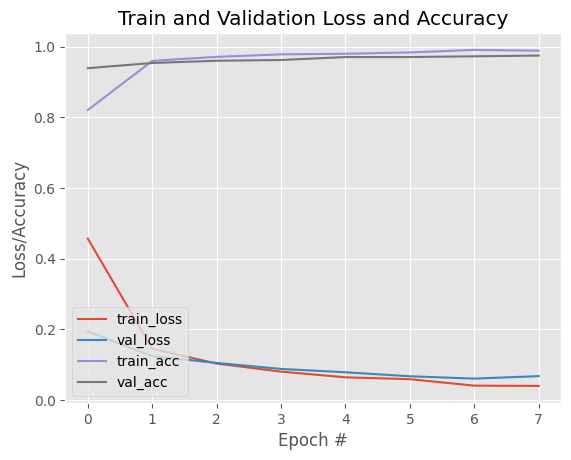

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs
	))
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Train and Validation Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [ ]:
resize = 224
size = 4
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
cascPath = os.path.join(cv2.data.haarcascades, "haarcascade_frontalface_alt2.xml")
faceCascade = cv2.CascadeClassifier(cascPath)
model = load_model("mask_detector.model")

cap = cv2.VideoCapture(0)
while True:

    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,
                                         scaleFactor=1.1,
                                         minNeighbors=5,
                                         minSize=(60, 60),
                                         flags=cv2.CASCADE_SCALE_IMAGE)
    faces_list = []
    for (x, y, w, h) in faces:
        face_frame = frame[y:y+h, x:x+w]
        face_frame = cv2.cvtColor(face_frame, cv2.COLOR_BGR2RGB)
        face_frame = cv2.resize(face_frame, (224, 224))
        face_frame = img_to_array(face_frame)
        face_frame = np.expand_dims(face_frame, axis=0)
        face_frame = preprocess_input(face_frame)
        faces_list.append(face_frame)
    if len(faces_list) > 0:
        preds = model.predict(faces_list)
    else:
        preds = []

    for (x, y, w, h), pred in zip(faces, preds):
        (mask_weared_incorrect, with_mask, without_mask) = pred

        if (with_mask > without_mask and with_mask > mask_weared_incorrect):
            label = "Mask Worn Properly :)"
            color = (0, 255, 0)
        elif (without_mask > with_mask and without_mask > mask_weared_incorrect):
            label = "No Mask! (please wear)"
            color = (0, 0, 255)
        else:
            label = "Wear Mask Properly!"
            color = (255, 140, 0)
        label = "{}: {:.2f}%".format(label,
                                     max(with_mask, mask_weared_incorrect, without_mask) * 100)
        cv2.putText(frame, label, (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
    cv2.imshow('LIVE', frame)
    key = cv2.waitKey(10)
    if key == 27:
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
image01 = cv2.resize(cv2.imread('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithMask/Augmented_151_4861419.png'), (resize, resize))
image01 = image01.astype("float") / 255.0
image01 = image01.reshape((1, image01.shape[0], image01.shape[1], image01.shape[2]))

image02 = cv2.resize(cv2.imread('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/incorrect_mask/aug_100.jpg'), (resize, resize))
image02 = image02.astype("float") / 255.0
image02 = image02.reshape((1, image02.shape[0], image02.shape[1], image02.shape[2]))

image03 = cv2.resize(cv2.imread('/content/drive/MyDrive/content/datasets/Face Mask Dataset/Train/WithoutMask/3059.png'), (resize, resize))
image03 = image03.astype("float") / 255.0
image03 = image03.reshape((1, image03.shape[0], image03.shape[1], image03.shape[2]))

labelz = ('with_mask', 'mask_weared_incorrect', 'without_mask')

predict = model.predict(image01, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image02, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

predict = model.predict(image03, verbose=1)
i = predict.argmax(axis=1)[0]
print(labelz[i])

1/1 [==============================] - 1s 1s/step
mask_weared_incorrect
1/1 [==============================] - 0s 25ms/step
without_mask
1/1 [==============================] - 0s 23ms/step
with_mask
